In [47]:
import sys
sys.path.insert(1, '/home/599/dbi599/xks/')
sys.path.insert(1, '../unseen')
import pdb
import warnings
warnings.filterwarnings('ignore')
import itertools

import numpy as np
import xarray as xr
import dask.array as da
from dask.distributed import Client, LocalCluster
import xclim.analog
import xskillscore as xs
import matplotlib.pyplot as plt

import fileio
import bootstrap
import xks

Matplotlib is building the font cache; this may take a moment.


In [2]:
cluster = LocalCluster() #n_workers=1, threads_per_worker=1)
client = Client(cluster)

In [3]:
client

Client Scheduler: tcp://127.0.0.1:45673 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 16 Memory: 44.92 GiB


## Read data

In [3]:
cafe_file = '/g/data/xv83/dbi599/ag/pr_cafe-c5-d60-pX-f6_19900501-20201101_A-DEC-mean_wheat-sheep-mean_bias-corrected-awap-additive.zarr.zip'
ds_cafe = fileio.open_file(cafe_file)
ds_cafe          

<xarray.Dataset>
Dimensions:    (ensemble: 96, init_date: 62, lead_time: 9, region: 4)
Coordinates:
  * ensemble   (ensemble) int64 1 2 3 4 5 6 7 8 9 ... 88 89 90 91 92 93 94 95 96
  * init_date  (init_date) object 1991-05-01 00:00:00 ... 2021-11-01 00:00:00
  * lead_time  (lead_time) int64 0 1 2 3 4 5 6 7 8
  * region     (region) <U10 'south-west' 'south-east' 'north-east' 'all'
    time       (lead_time, init_date) object dask.array<chunksize=(9, 62), meta=np.ndarray>
Data variables:
    pr         (init_date, lead_time, ensemble, region) float64 dask.array<chunksize=(1, 9, 96, 4), meta=np.ndarray>
Attributes:
    history:  Mon Aug 09 14:20:03 2021: /g/data/e14/dbi599/miniconda3/envs/un...

In [4]:
awap_file = '/g/data/xv83/dbi599/ag/pr_awap_1900-2020_A-DEC-mean_wheat-sheep-mean.zarr.zip'
ds_awap = fileio.open_file(awap_file, sel={'time': slice('1990-01-01', '2020-12-31')})
ds_awap

<xarray.Dataset>
Dimensions:  (region: 4, time: 31)
Coordinates:
  * region   (region) <U10 'south-west' 'south-east' 'north-east' 'all'
  * time     (time) object 1990-01-01 09:00:00 ... 2020-01-02 09:00:00
Data variables:
    pr       (time, region) float64 dask.array<chunksize=(1, 4), meta=np.ndarray>
Attributes:
    history:  Mon Aug 09 14:19:09 2021: /g/data/e14/dbi599/miniconda3/envs/un...

## 1D similarity test (K-S test)

In [6]:
fcst_stacked = ds_cafe.stack({'sample': ['ensemble', 'init_date',]})  # 'lead_time'
fcst_stacked = fcst_stacked.chunk({'sample': -1, 'region': 1})

In [7]:
fcst_stacked['pr']

<xarray.DataArray 'pr' (lead_time: 9, region: 4, sample: 5952)>
dask.array<rechunk-merge, shape=(9, 4, 5952), dtype=float64, chunksize=(9, 1, 5952), chunktype=numpy.ndarray>
Coordinates:
  * lead_time  (lead_time) int64 0 1 2 3 4 5 6 7 8
  * region     (region) <U10 'south-west' 'south-east' 'north-east' 'all'
    time       (lead_time, sample) object dask.array<chunksize=(9, 5952), meta=np.ndarray>
  * sample     (sample) MultiIndex
  - ensemble   (sample) int64 1 1 1 1 1 1 1 1 1 1 ... 96 96 96 96 96 96 96 96 96
  - init_date  (sample) object 1991-05-01 00:00:00 ... 2021-11-01 00:00:00
Attributes:
    bias_correction_method:  additive
    bias_correction_period:  1990-01-01-2020-12-31
    cell_methods:            time: mean
    interp_method:           conserve_order1
    long_name:               Total precipitation rate
    time_avg_info:           average_T1,average_T2,average_DT
    units:                   mm d-1

In [8]:
awap_faux_stacked = ds_awap.rename(time='sample')
awap_faux_stacked = awap_faux_stacked.chunk({'sample': -1, 'region': 1})
awap_faux_stacked['pr']

<xarray.DataArray 'pr' (sample: 31, region: 4)>
dask.array<rechunk-merge, shape=(31, 4), dtype=float64, chunksize=(31, 1), chunktype=numpy.ndarray>
Coordinates:
  * region   (region) <U10 'south-west' 'south-east' 'north-east' 'all'
  * sample   (sample) object 1990-01-01 09:00:00 ... 2020-01-02 09:00:00
Attributes:
    analysis_time:                 2010-10-23 14:49:46 UTC
    analysis_version_number:       3.01
    cell_methods:                  time: sum
    frequency:                     daily
    grid_mapping:                  crs
    length_scale_for_analysis:     80.0
    long_name:                     Daily precipitation
    number_of_stations_reporting:  2757
    source:                        Interpolated surface observations
    standard_name:                 lwe_thickness_of_precipitation_amount
    units:                         mm d-1
    valid_range:                   [-1.0, 100000.0]

In [31]:
#xclim.analog.spatial_analogs(target=awap_faux_stacked.compute(),
#                             candidates=fcst_stacked.compute(),
#                             dist_dim='sample',
#                             method='kolmogorov_smirnov')

xclim is super inefficient memory-wise for a 1D KS test. 

For a 2D KS-test I think you just include two variables in the Dataset instead of just one. For instance, at the moment `data_vars` only has one variable, but you could add another.

In [24]:
for lead_time in fcst_stacked['lead_time'].values:
    ks_obs, pvals_obs = xks.ks1d2s(awap_faux_stacked, fcst_stacked.sel({'lead_time': lead_time}), 'sample')
    print(f'# lead time: {lead_time}')
    print('KS distances:', ks_obs['pr'].values)
    print('p-values:', pvals_obs['pr'].values)

# lead time: 0
KS distances: [0.17741935 0.16817876 0.17305108 0.18766801]
p-values: [0.25478063 0.31206359 0.28082956 0.20070812]
# lead time: 1
KS distances: [0.16498656 0.15557796 0.1733871  0.18716398]
p-values: [0.33378127 0.40348329 0.27876052 0.20314361]
# lead time: 2
KS distances: [0.15658602 0.1577621  0.14936156 0.16817876]
p-values: [0.39561832 0.38656033 0.45396682 0.31206359]
# lead time: 3
KS distances: [0.15524194 0.1609543  0.16347446 0.18262769]
p-values: [0.40612546 0.36262555 0.34441418 0.22609122]
# lead time: 4
KS distances: [0.15994624 0.16969086 0.17943548 0.19438844]
p-values: [0.37008007 0.30212289 0.24337283 0.17034236]
# lead time: 5
KS distances: [0.16229839 0.17473118 0.18464382 0.20413306]
p-values: [0.35283693 0.27059353 0.2156619  0.13286994]
# lead time: 6
KS distances: [0.17489919 0.1780914  0.18615591 0.20732527]
p-values: [0.2695849  0.25093524 0.20808247 0.12215284]
# lead time: 7
KS distances: [0.17590726 0.17489919 0.19472446 0.20866935]
p-values

If p < 0.05 you can reject the null hypothesis that the two samples are from different populations.

# Resampling (bootstrapping)

Need to test random sub-samples from the forecast data (with same length as the observations) against the entire forecast sample to get the distribution of values you might expect if the observations come from the same population as the forecast. 

In [24]:
n_population = len(fcst_stacked['sample'])
n_population

53568

In [13]:
n_samples = len(awap_faux_stacked['sample'])
n_samples

31

### Single random sample

In [26]:
#samples = {'sample': (n_samples, 1)}
#fcst_random_sample = bootstrap.random_resample(fcst_stacked, samples=samples)
#fcst_random_sample

In [27]:
random_indexes = np.random.choice(n_population, size=n_samples, replace=True)

fcst_random_sample = fcst_stacked.isel({'sample': random_indexes})
fcst_random_sample

<xarray.Dataset>
Dimensions:    (region: 4, sample: 31)
Coordinates:
  * region     (region) <U10 'south-west' 'south-east' 'north-east' 'all'
    time       (sample) object dask.array<chunksize=(31,), meta=np.ndarray>
  * sample     (sample) MultiIndex
  - ensemble   (sample) int64 8 35 96 80 58 28 61 93 ... 43 10 18 12 75 54 86 36
  - init_date  (sample) object 1993-05-01 00:00:00 ... 2002-05-01 00:00:00
  - lead_time  (sample) int64 8 5 8 2 4 1 2 7 8 0 7 5 ... 2 2 5 6 8 6 5 5 7 7 1
Data variables:
    pr         (region, sample) float64 dask.array<chunksize=(1, 31), meta=np.ndarray>
Attributes:
    history:  Mon Aug 09 14:20:03 2021: /g/data/e14/dbi599/miniconda3/envs/un...

In [28]:
ks_random = xclim.analog.spatial_analogs(target=fcst_random_sample.compute(),
                                         candidates=fcst_stacked.compute(),
                                         dist_dim='sample',
                                         method='kolmogorov_smirnov')

In [30]:
ks_random

<xarray.DataArray 'dissimilarity' (region: 4)>
array([0.09404869, 0.19662858, 0.11226852, 0.09615815])
Coordinates:
  * region   (region) <U10 'south-west' 'south-east' 'north-east' 'all'
Attributes:
    long_name:  Dissimilarity between target and candidates, using metric kol...
    indices:    pr
    metric:     kolmogorov_smirnov

In [17]:
ks_random.values

distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Restarting worker


KilledWorker: ("('vectorize_kolmogorov_smirnov-vectorize_kolmogorov_smirnov_0-transpose-75bfca75d494758ee7913d2b4c0fb5b2', 1)", <WorkerState 'tcp://127.0.0.1:40117', name: 1, memory: 0, processing: 4>)

You get the same result no matter which array is the target and which is the candidate.

### n random samples

In [31]:
n_repeats = 3

In [29]:
#function = xclim.analog.spatial_analogs
#function_kwargs = {'candidates': fcst_stacked,
#                   'dist_dim': 'sample',
#                   'method': 'kolmogorov_smirnov'}
#
#dist = bootstrap.n_random_resamples(fcst_stacked,
#                                    samples=samples,
#                                    n_repeats=n_repeats,
#                                    function=function,
#                                    function_kwargs=function_kwargs,
#                                    bundle_args=False,
#                                    with_dask=True)

In [32]:
rs_list = []
for repeat in range(n_repeats):
    random_indexes = np.random.choice(n_population, size=n_samples, replace=True)
    fcst_random_sample = fcst_stacked.isel({'sample': random_indexes})
    ks_random = xclim.analog.spatial_analogs(target=fcst_random_sample.compute(),
                                             candidates=fcst_stacked.compute(),
                                             dist_dim='sample',
                                             method='kolmogorov_smirnov')
    rs_list.append(ks_random)

In [33]:
rs_list

[<xarray.DataArray 'dissimilarity' (region: 4)>
 array([0.1119325 , 0.19907407, 0.28005526, 0.26622237])
 Coordinates:
   * region   (region) <U10 'south-west' 'south-east' 'north-east' 'all'
 Attributes:
     long_name:  Dissimilarity between target and candidates, using metric kol...
     indices:    pr
     metric:     kolmogorov_smirnov,
 <xarray.DataArray 'dissimilarity' (region: 4)>
 array([0.12070639, 0.1192503 , 0.10299059, 0.09544878])
 Coordinates:
   * region   (region) <U10 'south-west' 'south-east' 'north-east' 'all'
 Attributes:
     long_name:  Dissimilarity between target and candidates, using metric kol...
     indices:    pr
     metric:     kolmogorov_smirnov,
 <xarray.DataArray 'dissimilarity' (region: 4)>
 array([0.1109431 , 0.22091547, 0.21171222, 0.25808318])
 Coordinates:
   * region   (region) <U10 'south-west' 'south-east' 'north-east' 'all'
 Attributes:
     long_name:  Dissimilarity between target and candidates, using metric kol...
     indices:    pr
     

In [36]:
xr.concat(rs_list, dim='k')

<xarray.DataArray 'dissimilarity' (k: 3, region: 4)>
array([[0.1119325 , 0.19907407, 0.28005526, 0.26622237],
       [0.12070639, 0.1192503 , 0.10299059, 0.09544878],
       [0.1109431 , 0.22091547, 0.21171222, 0.25808318]])
Coordinates:
  * region   (region) <U10 'south-west' 'south-east' 'north-east' 'all'
Dimensions without coordinates: k
Attributes:
    long_name:  Dissimilarity between target and candidates, using metric kol...
    indices:    pr
    metric:     kolmogorov_smirnov

## Independence test

You need to make sure that some lead times aren't correlated (i.e. because they still remember the initial conditions).

In [23]:
ds_cafe['init_date'].dt.month

<xarray.DataArray 'month' (init_date: 62)>
array([ 5, 11,  5, 11,  5, 11,  5, 11,  5, 11,  5, 11,  5, 11,  5, 11,  5,
       11,  5, 11,  5, 11,  5, 11,  5, 11,  5, 11,  5, 11,  5, 11,  5, 11,
        5, 11,  5, 11,  5, 11,  5, 11,  5, 11,  5, 11,  5, 11,  5, 11,  5,
       11,  5, 11,  5, 11,  5, 11,  5, 11,  5, 11])
Coordinates:
  * init_date  (init_date) object 1991-05-01 00:00:00 ... 2021-11-01 00:00:00

In [52]:
ds_cafe_may = ds_cafe.where(ds_cafe['init_date'].dt.month == 5, drop=True)
ds_cafe_nov = ds_cafe.where(ds_cafe['init_date'].dt.month == 11, drop=True)

In [99]:
def remove_ensemble_mean_trend(da, dim='init_date'):
    """Remove ensemble mean trend along given dimension
    
    Args:
      da (xarray DataArray)
      dim (str) : Dimension over which to calculate and remove trend
    """
    
    ensmean_trend = da.mean('ensemble').polyfit(dim=dim, deg=1)
    ensmean_trend_line = xr.polyval(da[dim], ensmean_trend['polyfit_coefficients'])
    ensmean_trend_line_anomaly = ensmean_trend_line - ensmean_trend_line.isel({dim:0})
    da_detrended = da - ensmean_trend_line_anomaly
                            
    return da_detrended

In [102]:
da_cafe_may_detrended = remove_ensemble_mean_trend(ds_cafe_may['pr'], dim='init_date')
da_cafe_nov_detrended = remove_ensemble_mean_trend(ds_cafe_nov['pr'], dim='init_date')

In [112]:
def mean_ensemble_correlation(da, dim='init_date'):
    """Mean correlation between all ensemble members.
    
    Args:
      da (xarray DataArray)
      dim (str) : Dimension over which to calculate correlation
    """

    n_ensemble_members = len(da['ensemble'])
    combinations = np.array(list(itertools.combinations(range(n_ensemble_members), 2)))
    
    new_ensemble_coord = {'ensemble': range(combinations.shape[0])}                 
    e1 = da.isel(ensemble=combinations[:,0]).assign_coords(new_ensemble_coord)
    e2 = da.isel(ensemble=combinations[:,1]).assign_coords(new_ensemble_coord)

    e1 = e1.chunk({dim: -1})
    e2 = e2.chunk({dim: -1})
                            
    corr_combinations = xs.spearman_r(e1, e2, dim=dim, skipna=True)
    mean_corr = corr_combinations.mean('ensemble')
    
    return mean_corr

In [116]:
mean_corr_may = mean_ensemble_correlation(da_cafe_may_detrended, dim='init_date')
mean_corr_nov = mean_ensemble_correlation(da_cafe_nov_detrended, dim='init_date')

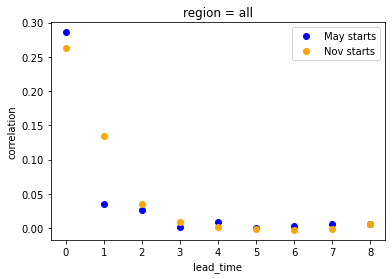

In [120]:
mean_corr_may.sel({'region': 'all'}).plot(color='blue', marker='o', linestyle='None', label=f'May starts')
mean_corr_nov.sel({'region': 'all'}).plot(color='orange', marker='o', linestyle='None', label=f'Nov starts')
plt.ylabel('correlation')
plt.legend()
plt.show()